# Diffusion models

The diffusion model, proposed by Dickstein et al. in 2015, is inspired by techniques from nonequilibrium thermodynamics [1]. It involves the process of gradually adding Gaussian noise to natural images, leading to a final state where the image distribution approximates a Gaussian distribution. The idea of the diffusion model is to learn the reverse process: starting from a Gaussian distribution and iteratively denoising to recover the original image. By learning this reverse process, the model can generate new samples by first sampling from a Gaussian distribution and then applying the learned reverse process to produce new images.

```{image} ddpm.png
:alt: fishy
:class: bg-primary mb-1
:width: 700px
:align: center
```

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 1 </strong>: Diffusion model architecture (Source: [2])
</p>


## Diffusion model: the objective

Formally, let $\mathbf{x}_0$ denote the original image. We define a forward process $q(\mathbf{x}_t|\mathbf{x}_{t-1})$ which adds noise according to some variance schedule $\{\beta_t\}\in (0,1)$.

$$q(\mathbf{x}_t|\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t|\sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t \mathbf{I})$$

To see what happens asymptotically, consider letting $\alpha_t=1-\beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$, we have

$$
\begin{align*}
    \mathbf{x}_t&= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1-\alpha_t} \epsilon_{t-1}\\
    &= \sqrt{\alpha_t}(\sqrt{\alpha_{t-1}}\mathbf{x}_{t-2} + \sqrt{1-\alpha_{t-1}}\epsilon_{t-2}) + \sqrt{1-\alpha_t}\epsilon_{t-1}\\
    &= \sqrt{\alpha_t\alpha_{t-1}}\mathbf{x}_{t-2} + \sqrt{1-\alpha_t\alpha_{t-1}}\epsilon_{t-3}\\
    &= \sqrt{\bar{\alpha}_t} \mathbf{x}_{0} + \sqrt{1-\bar{\alpha}_t}\epsilon
\end{align*}
$$

Since $\alpha_t\in (0,1)$, we see that $\bar{\alpha}_t\rightarrow 0$ as $t\to\infty$. This suggests that as $t\to\infty$, we have

$$q(\mathbf{x}_t|\mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t|\sqrt{\bar{\alpha}_t} \mathbf{x}_{0}, (1-\bar{\alpha}_t)\mathbf{I})\rightarrow \mathcal{N}(\mathbf{0}, \mathbf{I})$$

In other words, the distribution converges to an isotropic Gaussian as we continue to add noise. To be able to generate new images, we want to learn the reverse process. In particular, we want to learn the distribution $q(\mathbf{x}_{t-1}|\mathbf{x}_t)$. Unfortunately, we can not easily estimate $q(\mathbf{x}_{t-1}|\mathbf{x}_t)$. Therefore, we use a parameterized family of distributions $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)$ to estimate $q(\mathbf{x}_{t-1}|\mathbf{x}_t)$. Note that this is essentially a latent variable model with latent variables being $\mathbf{z}=\mathbf{x}_{1:T}$. Therefore, applying the variational lower bound, we have 

$$
\begin{align*}
\log p(\mathbf{x}_0) &\geq \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} [\log p(\mathbf{x}_0|\mathbf{x}_{1:T})] - \mathcal{D}_{KL}(q(\mathbf{x}_{1:T}|\mathbf{x}_0)||p(\mathbf{x}_{1:T}))\\
    &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[\log \frac{p(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}|\mathbf{x}_0)}\bigg]\\
    &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[\log \frac{p(\mathbf{x}_T)p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)\prod_{t=1}^{T-1}p_{\theta}(\mathbf{x}_{t}|\mathbf{x}_{t+1})}{q(\mathbf{x}_T|\mathbf{x}_{T-1})\prod_{t=1}^{T-1} q(\mathbf{x}_t|\mathbf{x}_{t-1})}\bigg]\\
    &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0}[p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)] + \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[\log\frac{p(\mathbf{x}_T)}{q(\mathbf{x}_T|\mathbf{x}_{T-1})}\bigg] + \sum_{i=1}^{T-1} \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[\frac{p_{\theta}(\mathbf{x}_{t}|\mathbf{x}_{t+1})}{q(\mathbf{x}_t|\mathbf{x}_{t-1})}\bigg]\\
    &= \mathbb{E}_{\mathbf{x}_{1}|\mathbf{x}_0}[p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)] + \mathbb{E}_{\mathbf{x}_{T-1}, \mathbf{x}_T|\mathbf{x}_0} \bigg[\log\frac{p(\mathbf{x}_T)}{q(\mathbf{x}_T|\mathbf{x}_{T-1})}\bigg] + \sum_{i=1}^{T-1} \mathbb{E}_{\mathbf{x}_{t-1}, \mathbf{x}_{t}, \mathbf{x}_{t+1}|\mathbf{x}_{0}} \bigg[\frac{p_{\theta}(\mathbf{x}_{t}|\mathbf{x}_{t+1})}{q(\mathbf{x}_t|\mathbf{x}_{t-1})}\bigg]\\
    &= \underbrace{\mathbb{E}_{\mathbf{x}_{1}|\mathbf{x}_0}[p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)]}_{\text{reconstruction term}} + 
    \underbrace{\mathbb{E}_{\mathbf{x}_{T-1}|\mathbf{x}_0} [\mathcal{D}_{KL}(q(\mathbf{x}_T|\mathbf{x}_{T-1})||p(\mathbf{x}_T))]}_{\text{prior matching term}}
    + \sum_{i=1}^{T-1} \underbrace{\mathbb{E}_{\mathbf{x}_{t-1}, \mathbf{x}_{t+1}|\mathbf{x}_{0}} [\mathcal{D}_{KL}(q(\mathbf{x}_t|\mathbf{x}_{t-1})||p_{\theta}(\mathbf{x}_{t}|\mathbf{x}_{t+1}))]}_{\text{consistency term}}\\
\end{align*}
$$

Like the case for variational autoencoder, the variational lower bound consists of three terms

1. Reconstruction term:  measures the likelihood of reconstruction in the first latent layer.
2. Prior matching term: ensures that the learned final latent distribution matches the prior distribution.
3. Consistency term: the denoising step from a noisier image should match the corresponding noising step from a cleaner image

Given a collection of images, once we noised these images, we can estimate the loss above using Monte Carlo methods. By using stochastic gradient descent, we can solve for the optimal parameters. 

## A Lower Variance Estimate


$$
\begin{align*}
     \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[\log \frac{p(\mathbf{x}_{1:T}|\mathbf{x}_0)}{p(\mathbf{x}_{0:T})}\bigg] &=  \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[\log\frac{\prod_{t=1}^T q(\mathbf{x}_{t}|\mathbf{x}_{t-1})}{p(\mathbf{x}_T)\prod_{t=1}^T p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[-\log p(\mathbf{x}_T) + \sum_{t=1}^T \log \frac{ q(\mathbf{x}_{t}|\mathbf{x}_{t-1})}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}\bigg]\\
\end{align*}
$$

We can further simplify the work by noting that. This gives us

$$
\begin{align*}
     \log p(\mathbf{x}_0) &\geq \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[-\log p(\mathbf{x}_T) + \sum_{t=1}^T \log \frac{ q(\mathbf{x}_{t}|\mathbf{x}_{t-1})}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[-\log p(\mathbf{x}_T) + \sum_{t=1}^T \log \bigg(\frac{ q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}\cdot \frac{q(\mathbf{x}_{t}|\mathbf{x}_0)}{q(\mathbf{x}_{t-1}|\mathbf{x}_0)}\bigg)+\log \frac{q(\mathbf{x}_1|\mathbf{x}_0}{p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)}\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[-\log p(\mathbf{x}_T) + \sum_{t=1}^T \log \frac{ q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}+\sum_{t=1}^T \log\frac{q(\mathbf{x}_{t}|\mathbf{x}_0)}{q(\mathbf{x}_{t-1}|\mathbf{x}_0)}+\log \frac{q(\mathbf{x}_1|\mathbf{x}_0)}{p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)}\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[-\log p(\mathbf{x}_T) + \sum_{t=1}^T \log \frac{ q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}+\sum_{t=1}^T \log\frac{q(\mathbf{x}_{t}|\mathbf{x}_0)}{q(\mathbf{x}_{t-1}|\mathbf{x}_0)}+\log \frac{q(\mathbf{x}_1|\mathbf{x}_0)}{p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)}\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{1:T}|\mathbf{x}_0} \bigg[\log\frac{q(\mathbf{x}_T|\mathbf{x}_0)}{p(\mathbf{x}_T)} + \sum_{t=1}^T \log \frac{ q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}-\log p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)\bigg]\\
     &= \mathbb{E}_{\mathbf{x}_{T}|\mathbf{x}_0} \bigg[\log\frac{q(\mathbf{x}_T|\mathbf{x}_0)}{p(\mathbf{x}_T)}\bigg] + \sum_{t=2}^T \mathbb{E}_{\mathbf{x}_{t-1}, \mathbf{x}_{t}|\mathbf{x}_0}\bigg[\log \frac{ q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)}{p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)}\bigg]- \mathbb{E}_{\mathbf{x}_{1}|\mathbf{x}_0}\bigg[\log p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)\bigg]\\
     &= \text{KL}(q(\mathbf{x}_T|\mathbf{x}_0)||p(\mathbf{x}_T)) + \sum_{t=2}^T \mathbb{E}_{ \mathbf{x}_{t}|\mathbf{x}_0}[\text{KL}(q(\mathbf{x}_{t-1}|\mathbf{x}_{t}, \mathbf{x}_0)||p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t))] - \mathbb{E}_{\mathbf{x}_{1}|\mathbf{x}_0}[\log p_{\theta}(\mathbf{x}_0|\mathbf{x}_1)]\\
\end{align*}
$$

Now each of the expectation only requires sampling over one random variable. This gives a lower variance estiamte. 

## A Simpler Training Scheme

It turns out that 

$$q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \underbrace{\frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})\mathbf{x}_t+\sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)\mathbf{x}_0}{1-\bar{\alpha}_t}}_{\mu_q(\mathbf{x}_t, \mathbf{x}_0)}, \underbrace{\frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}}_{\Sigma(t)}\mathbf{I})$$

Next, recall that

$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_{0} + \sqrt{1-\bar{\alpha}_t}\epsilon \implies \mathbf{x}_0=\frac{1}{\sqrt{\bar{\alpha_t}}}\bigg(\mathbf{x}_t - \sqrt{1-\bar{\alpha}_t}\epsilon_t\bigg)$$

Substituting into $\mu_q(\mathbf{x}_t, \mathbf{x}_0)$, we see that

$$\mu_q(\mathbf{x}_t, \mathbf{x}_0) = \frac{1}{\sqrt{\alpha_t}}\bigg(\mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_t\bigg)$$

Since $p_\theta(\mathbf{x}_t|\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t|\mu_{\theta}, \Sigma_\theta)$, by reparameterizing 

$$\mu_{\theta}=\frac{1}{\sqrt{\alpha_t}}\bigg(\mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta\bigg)$$

Then the loss term can be written as 

$$
\begin{align*}
    L_t &= \mathbb{E}_{\mathbf{x}_0, \epsilon}\bigg[\frac{1}{2\|\Sigma_\theta\|_2^2}\|\mu_t(\mathbf{x}_t, \mathbf{x}_0) - \mu_{\theta}(\mathbf{x}_t, t)\|_2^2\bigg]\\
    &= \mathbb{E}_{\mathbf{x}_0, \epsilon}\bigg[\frac{(1-\alpha_t)^2}{2\alpha_t(1-\bar{\alpha}_t)\|\Sigma_\theta\|_2^2}\|\epsilon_t - \epsilon_{\theta}(\mathbf{x}_t, t)\|_2^2\bigg]\\
    &= \mathbb{E}_{\mathbf{x}_0, \epsilon}\bigg[\frac{(1-\alpha_t)^2}{2\alpha_t(1-\bar{\alpha}_t)\|\Sigma_\theta\|_2^2}\|\epsilon_t - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t} \mathbf{x}_{0} + \sqrt{1-\bar{\alpha}_t}\epsilon, t)\|_2^2\bigg]\\
\end{align*}
$$

In DDPM, Ho et al. noticed that training the diffusion model works better if we ignore the weighing factor. The final loss is given by 

$$L_t = \mathbb{E}_{t\sim[1, T]\mathbf{x}_0, \epsilon}\bigg[\|\epsilon_t - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t} \mathbf{x}_{0} + \sqrt{1-\bar{\alpha}_t}\epsilon, t)\|_2^2\bigg]$$

And this gives the final algorithm for training a diffusion model.

```{image} algorithm.png
:alt: fishy
:class: bg-primary mb-1
:width: 500px
:align: center
```

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 2 </strong>: Algorithm for training diffusion model (Source: [2])
</p>

## Toy example: Swiss Roll

We now implement a toy diffusion model to model the distribution of the swiss roll dataset. We use $100000$ points as our training data.

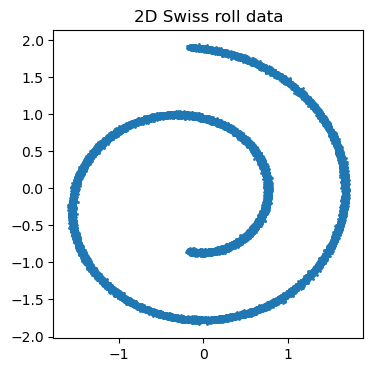

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

X, _ = make_swiss_roll(n_samples=100000, noise=0.1)
X = X[:, [0, 2]]
X = (X - X.mean()) / X.std()
X = torch.tensor(X)
plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.title("2D Swiss roll data")
plt.show()

We set the number of timesteps $T=50$. The variance schedule follows a linear schedule from $10^{-3}$ to $0.02$. The noising process is shown below. We see that the swiss roll data eventually becomes a unit Gaussian as we continue to add noise. 

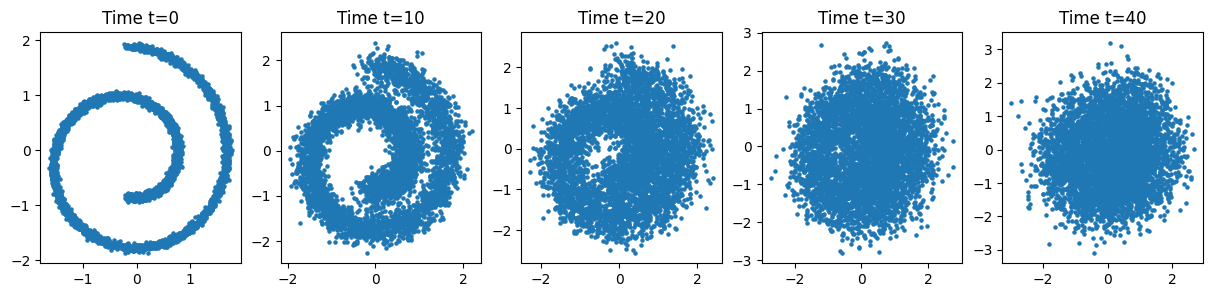

In [ ]:
T = 50
beta = np.linspace(1e-3, 2e-2, T)
alpha_ = np.cumprod(1-beta)

def add_noise(X, t, alpha):
    alpha = torch.tensor(alpha)
    eps = torch.randn(size=X.shape)
    X_noised = (alpha[t] ** 0.5).repeat(1, X.shape[1]) * X + ((1 - alpha[t]) ** 0.5).repeat(1, X.shape[1]) * eps
    return X_noised, eps

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(0, T, T // 5):
    X_noised, _ = add_noise(X[:5000], i, alpha_)
    ax[i // (T // 5)].scatter(X_noised[:, 0], X_noised[:, 1], s=5)
    ax[i // (T // 5)].set_title(f"Time t={i}")
plt.show()

To model the noise, we use a simple feedforward network with $3$ hidden layers. Before passing the points into the network, we concatenate it with the current timestep. 

In [ ]:
class SimpleDiffusion(nn.Module):

    def __init__(self, hidden_dim, in_dim=3, out_dim=2):
        super(SimpleDiffusion, self).__init__()
        self.noise = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x, t):
        x = torch.cat((x, t * torch.ones(x.shape[0], 1)), dim=1).float()
        noise = self.noise(x)
        return noise

In [ ]:
def train(X, model, alpha_, n_epoch=100, T=10, batch_size=1024, print_every=1, lr=0.001):
    train_loss = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    for epoch in range(n_epoch):
        epoch_loss = 0.0
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            t = np.random.randint(T)
            X_noised, eps = add_noise(X_batch, t, alpha_)
            eps_pred = model(X_noised, (t / T))
            loss = nn.MSELoss()(eps_pred, eps)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        epoch_loss = epoch_loss * batch_size / len(X)
        train_loss.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}") if epoch % print_every == 0 else None
    return train_loss

We trained a simple diffusion model with a hidden dimension of $64$ for $100$ epochs, using a learning rate of $10^{-4}$. The figure below illustrates the denoising process, demonstrating that the model successfully learns to denoise. The generated samples resemble the Swiss roll dataset.

In [ ]:
model = SimpleDiffusion(hidden_dim=64)
train_loss = train(X, model, alpha_, n_epoch=100, T=T, print_every=20, lr=1e-4)

In [ ]:
def sample(model, n, beta, alpha, alpha_):
    X = torch.randn(n, 2)
    X_t = [X]
    model.eval()
    with torch.no_grad():
        for t in range(T-1, 0, -1):
            eps_pred = model(X, (t / T))
            X = 1 / (alpha[t] ** 0.5) * (X - (1 - alpha[t]) / ((1-alpha_[t]) ** 0.5) * eps_pred)
            X += beta[t]**2 * torch.randn(n, 2)
            X_t.append(X)
    X_t = torch.stack(X_t)
    return X_t

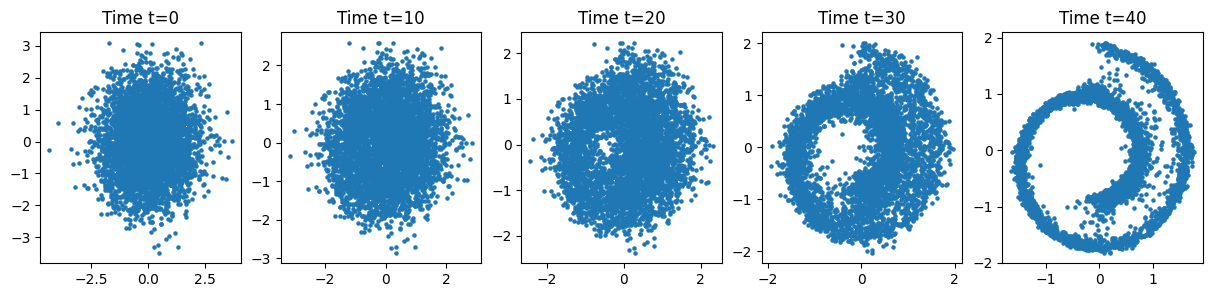

In [ ]:
samples = sample(model, 5000, beta, 1-beta, alpha_)

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(0, T, T // 5):
    X_sampled = samples[i]
    ax[i // (T // 5)].scatter(X_sampled[:, 0], X_sampled[:, 1], s=5)
    ax[i // (T // 5)].set_title(f"Time t={i}")
plt.show()

<span style="font-size:20px;"><strong>Citations</strong></span>

[1] https://arxiv.org/abs/1503.03585 <br>
[2] https://arxiv.org/abs/2006.11239 <br>
[3] https://lilianweng.github.io/posts/2021-07-11-diffusion-models/ <br>